In [1]:
!git clone https://github.com/deepsolar/pynlfff.git

Cloning into 'pynlfff'...
remote: Enumerating objects: 13269, done.
remote: Counting objects: 100% (987/987), done.
remote: Compressing objects: 100% (437/437), done.
remote: Total 13269 (delta 453), reused 915 (delta 410), pack-reused 12282 (from 1)
Receiving objects: 100% (13269/13269), 10.67 MiB | 19.48 MiB/s, done.
Resolving deltas: 100% (1400/1400), done.


In [2]:
!pip install sunpy[all] pfsspy pynlfff

from IPython.display import clear_output
clear_output()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sunpy.net import Fido, attrs as a
from astropy.time import Time
from astropy.io import fits
from astropy import units as u
from datetime import datetime

# Prepare  data

In [4]:
# Downloading an active region

query = Fido.search(
    a.jsoc.Time("2025-11-11T10:04", "2025-11-11T10:04"),
    a.jsoc.Series("hmi.sharp_cea_720s"),
    *[a.jsoc.Segment(seg) for seg in ["Bp","Br","Bt"]],
    a.jsoc.PrimeKey("HARPNUM", 13999),
    a.jsoc.Notify("vivoY75user@gmail.com"))

In [5]:
result = Fido.fetch(query, path="/content/nlfff_gpu/data/raw/")

INFO:sunpy:3 URLs found for download. Full request totaling 3MB


INFO: 3 URLs found for download. Full request totaling 3MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

hmi.sharp_cea_720s.13999.20251111_100000_TAI.Bp.fits:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

hmi.sharp_cea_720s.13999.20251111_100000_TAI.Bt.fits:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

hmi.sharp_cea_720s.13999.20251111_100000_TAI.Br.fits:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

In [6]:
br_data = fits.open("/content/nlfff_gpu/data/raw/hmi.sharp_cea_720s.13999.20251111_100000_TAI.Br.fits")[1].data
bp_data = fits.open("/content/nlfff_gpu/data/raw/hmi.sharp_cea_720s.13999.20251111_100000_TAI.Bp.fits")[1].data
bt_data = fits.open("/content/nlfff_gpu/data/raw/hmi.sharp_cea_720s.13999.20251111_100000_TAI.Bt.fits")[1].data

br_data.shape

(441, 1512)

In [7]:
# Crop Br_data to include 400-800 pixels in x and 150-350 in y
y_start = 149  # Corresponds to pixel 150 (0-indexed)
y_end = 400    # Corresponds to pixel 350
x_start = 399  # Corresponds to pixel 400 (0-indexed)
x_end = 700    # Corresponds to pixel 800

Bp_data = bp_data[y_start:y_end, x_start:x_end]
Bt_data = bt_data[y_start:y_end, x_start:x_end]
Br_data = br_data[y_start:y_end, x_start:x_end]

# Update nx, ny based on new cropped data shape if needed for subsequent cells
ny, nx = Br_data.shape
print(f"New cropped size: nx={nx}, ny={ny}")

New cropped size: nx=301, ny=251


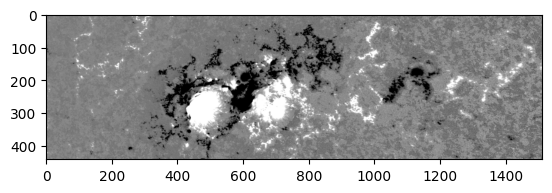

In [8]:
plt.imshow(br_data, cmap = "grey", vmin = -500, vmax = 500)

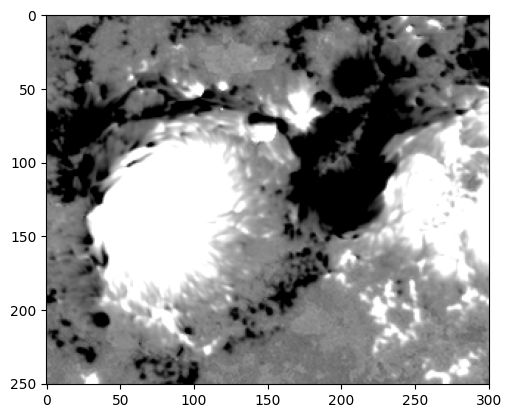

In [9]:
plt.imshow(Br_data, cmap = "grey", vmin = -500, vmax = 500)

# Creating the input files

### boundary.ini

In [10]:
!mkdir "/content/input_files/"

In [11]:
# Set injection speed
nue = 0.001

with open("/content/input_files/boundary.ini", "w") as f:
    f.write(f"nue {nue}\n")
    f.write("Mask B_T/max(B_T)\n")

print(f"boundary.ini written successfully!")

boundary.ini written successfully!


## Level 1

### allboundaries3.dat

In [12]:
br_data = fits.open("/content/nlfff_gpu/data/raw/hmi.sharp_cea_720s.13999.20251111_100000_TAI.Br.fits")[1].data
bp_data = fits.open("/content/nlfff_gpu/data/raw/hmi.sharp_cea_720s.13999.20251111_100000_TAI.Bp.fits")[1].data
bt_data = fits.open("/content/nlfff_gpu/data/raw/hmi.sharp_cea_720s.13999.20251111_100000_TAI.Bt.fits")[1].data

In [13]:
ny0, nx0 = Br_data.shape
print("Original size:", nx0, ny0)

nx = (nx0 // 4) * 4
ny = (ny0 // 4) * 4
nz = int(((3/8 *(nx + ny)) // 4) * 4)

x0 = (nx0 - nx) // 2
y0 = (ny0 - ny) // 2

Bp_data = Bp_data[y0:y0+ny, x0:x0+nx]
Bt_data = Bt_data[y0:y0+ny, x0:x0+nx]
Br_data = Br_data[y0:y0+ny, x0:x0+nx]

print("Cropped size:", nx, ny)

Original size: 301 251
Cropped size: 300 248


In [14]:
def flux_balance(Bz):
    mean_flux = np.mean(Bz)
    return Bz - mean_flux

Br_data = flux_balance(Br_data)

def apodize(B, width=20):
    ny, nx = B.shape
    wx = np.ones(nx)
    wy = np.ones(ny)

    for i in range(width):
        w = 0.5*(1 - np.cos(np.pi*i/width))
        wx[i] = w
        wx[-i-1] = w
        wy[i] = w
        wy[-i-1] = w

    window = np.outer(wy, wx)
    return B * window

Br_data = apodize(Br_data)
Bp_data = apodize(Bp_data)
Bt_data = apodize(Bt_data)


In [15]:
# Moving to cartesian coordinates
b3dx = Bp_data
b3dy = - Bt_data
b3dz = Br_data

# Flattening in fortran order
Bx_f = b3dx.flatten(order='F')
By_f = b3dy.flatten(order='F')
Bz_f = b3dz.flatten(order='F')

In [16]:
# Writing to allboundaries.dat
with open("/content/input_files/allboundaries3.dat", "w") as f:
    for i in range(len(Bx_f)):
        f.write(f"{Bx_f[i]:.6e} {By_f[i]:.6e} {Bz_f[i]:.6e}\n")

print("allboundaries3.dat written successfully")

allboundaries3.dat written successfully


### mask3.dat

In [17]:
B_T = np.sqrt(b3dx**2 + b3dy**2)

# parameter W
W = B_T / np.max(B_T)

# Flattening in fortran order
W_f = W.flatten(order='F')

# Writing to mask3.dat
with open("/content/input_files/mask3.dat", "w") as f:
    for v in W_f:
        f.write(f"{v:.6e}\n")
print("mask3.dat written successfully!")

mask3.dat written successfully!


### grid3.ini

In [18]:
nd = 0
with open("/content/input_files/grid3.ini", "w") as f:
    f.write(f"nx {nx}\n")
    f.write(f"ny {ny}\n")
    f.write(f"nz {nz}\n")
    f.write(f"nd {nd}\n")

print("grid3.ini written successfully!")

grid3.ini written successfully!


## Level 2

### allboundaries2.dat

In [20]:
# Downsampling to grid2
nx2 = nx//2
ny2 = ny//2
nz2 = nz//2

# Arrays are (ny, nx). Group as (ny2, 2, nx2, 2) then average pairs along both axes.
b2dx = b3dx.reshape(ny2, 2, nx2, 2).mean(axis=(1,3))
b2dy = b3dy.reshape(ny2, 2, nx2, 2).mean(axis=(1,3))
b2dz = b3dz.reshape(ny2, 2, nx2, 2).mean(axis=(1,3))

# Flattening in fortran order
Bx2_f = b2dx.flatten(order='F')
By2_f = b2dy.flatten(order='F')
Bz2_f = b2dz.flatten(order='F')

In [21]:
# Writing to allboundaries.dat
with open("/content/input_files/allboundaries2.dat", "w") as f:
    for i in range(len(Bx2_f)):
        f.write(f"{Bx2_f[i]:.6e} {By2_f[i]:.6e} {Bz2_f[i]:.6e}\n")

print("allboundaries2.dat written successfully")

allboundaries2.dat written successfully


### mask2.dat

In [22]:
B2_T = np.sqrt(b2dx**2 + b2dy**2)

# parameter W
W2 = B2_T / np.max(B2_T)

# Flattening in fortran order
W2_f = W2.flatten(order='F')

# Writing to mask3.dat
with open("/content/input_files/mask2.dat", "w") as f:
    for v in W2_f:
        f.write(f"{v:.6e}\n")
print("mask2.dat written successfully!")

mask2.dat written successfully!


### grid2.ini

In [23]:
nd = 0
with open("/content/input_files/grid2.ini", "w") as f:
    f.write(f"nx {nx2}\n")
    f.write(f"ny {ny2}\n")
    f.write(f"nz {nz2}\n")
    f.write(f"nd {nd}\n")

print("grid2.ini written successfully!")

grid2.ini written successfully!


## Level 3

### allboundaries1.dat

In [24]:
# Downsample again to grid 1
nx1 = nx2 // 2
ny1 = ny2 // 2
nz1 = nz2 // 2

b1dx = b2dx.reshape(ny1, 2, nx1, 2).mean(axis=(1, 3))
b1dy = b2dy.reshape(ny1, 2, nx1, 2).mean(axis=(1, 3))
b1dz = b2dz.reshape(ny1, 2, nx1, 2).mean(axis=(1, 3))

# Flatten for fortran order
Bx1_f = b1dx.flatten(order='F')
By1_f = b1dy.flatten(order='F')
Bz1_f = b1dz.flatten(order='F')

In [25]:
# Writing to allboundaries.dat
with open("/content/input_files/allboundaries1.dat", "w") as f:
    for i in range(len(Bx1_f)):
        f.write(f"{Bx1_f[i]:.6e} {By1_f[i]:.6e} {Bz1_f[i]:.6e}\n")

print("allboundaries1.dat written successfully")

allboundaries1.dat written successfully


### mask1.dat

In [26]:
B1_T = np.sqrt(b1dx**2 + b1dy**2)

# parameter W
W1 = B1_T / np.max(B1_T)

# Flattening in fortran order
W1_f = W1.flatten(order='F')

# Writing to mask1.dat
with open("/content/input_files/mask1.dat", "w") as f:
    for v in W1_f:
        f.write(f"{v:.6e}\n")
print("mask1.dat written successfully!")

mask1.dat written successfully!


### grid1.ini

In [27]:
nd = 0
with open("/content/input_files/grid1.ini", "w") as f:
    f.write(f"nx {nx1}\n")
    f.write(f"ny {ny1}\n")
    f.write(f"nz {nz1}\n")
    f.write(f"nd {nd}\n")

print("grid1.ini written successfully!")

grid1.ini written successfully!


In [28]:
# Quick validation of shapes, NaNs, and consistency
import numpy as np

def report_stats(name, A):
    print(f"{name}: shape={A.shape}, nan={np.isnan(A).sum()}, min={np.nanmin(A):.3f}, max={np.nanmax(A):.3f}, mean={np.nanmean(A):.3f}")

print("=== Level 3 (native) ===")
report_stats("Bp_data", Bp_data)
report_stats("Bt_data", Bt_data)
report_stats("Br_data", Br_data)
print(f"nx={nx}, ny={ny}, nz={nz}")

print("\n=== Level 2 (downsampled) ===")
report_stats("b2dx", b2dx)
report_stats("b2dy", b2dy)
report_stats("b2dz", b2dz)
print(f"nx2={nx2}, ny2={ny2}, nz2={nz2}")

print("\n=== Level 1 (downsampled) ===")
report_stats("b1dx", b1dx)
report_stats("b1dy", b1dy)
report_stats("b1dz", b1dz)
print(f"nx1={nx1}, ny1={ny1}, nz1={nz1}")

# Basic consistency checks
assert Bp_data.shape == (ny, nx) and Bt_data.shape == (ny, nx) and Br_data.shape == (ny, nx), "Input component shapes mismatch"
assert b2dx.shape == (ny2, nx2) and b1dx.shape == (ny1, nx1), "Downsampled shapes mismatch"
assert len(open("/content/input_files/allboundaries3.dat").read().splitlines()) == nx*ny, "allboundaries3.dat line count mismatch"
print("\nValidation passed: shapes and file line counts look consistent.")

=== Level 3 (native) ===
Bp_data: shape=(248, 300), nan=0, min=-2429.720, max=1488.110, mean=-57.723
Bt_data: shape=(248, 300), nan=0, min=-2023.980, max=1448.720, mean=-128.626
Br_data: shape=(248, 300), nan=0, min=-3044.623, max=2794.477, mean=14.282
nx=300, ny=248, nz=204

=== Level 2 (downsampled) ===
b2dx: shape=(124, 150), nan=0, min=-2403.345, max=1471.055, mean=-57.723
b2dy: shape=(124, 150), nan=0, min=-1437.215, max=1935.778, mean=128.626
b2dz: shape=(124, 150), nan=0, min=-2393.600, max=2767.622, mean=14.282
nx2=150, ny2=124, nz2=102

=== Level 1 (downsampled) ===
b1dx: shape=(62, 75), nan=0, min=-2162.093, max=1450.452, mean=-57.723
b1dy: shape=(62, 75), nan=0, min=-1364.564, max=1819.780, mean=128.626
b1dz: shape=(62, 75), nan=0, min=-2224.809, max=2735.546, mean=14.282
nx1=75, ny1=62, nz1=51

Validation passed: shapes and file line counts look consistent.


# Using the solver

In [29]:
import os

# Change to the wiegelmann_nlfff directory
original_dir = os.getcwd()
os.chdir('/content/pynlfff/pynlfff/cnlfff/wiegelmann_nlfff/')

# Compile the code for cpu.parallel.amd (x86_64)
!make -f Makefile.cpu.p.amd

# Change back to the original directory
os.chdir(original_dir)

# Now, try to run the multigrid.cpu.sh script, assuming it will use the newly compiled binaries
# The script multigrid.cpu.sh is also in the same directory
# We will need to adjust the path to the binaries inside multigrid.cpu.sh if it hardcodes the 'arm' path.
!bash /content/pynlfff/pynlfff/cnlfff/wiegelmann_nlfff/multigrid.cpu.sh /content/input_files 123

gcc -c -g -O5 -fopenmp relax1.c -o relax1.o
relax1.c: In function ‘main’:
relax1.c:156:24: warning: format ‘%s’ expects argument of type ‘char *’, but argument 3 has type ‘char (*)[25]’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wformat=-Wformat=]8;;]
  156 |     fscanf(initfile, "%s %i", &leer, &nx);
      |                       ~^      ~~~~~
      |                        |      |
      |                        char * char (*)[25]
relax1.c:157:24: warning: format ‘%s’ expects argument of type ‘char *’, but argument 3 has type ‘char (*)[25]’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wformat=-Wformat=]8;;]
  157 |     fscanf(initfile, "%s %i", &leer, &ny);
      |                       ~^      ~~~~~
      |                        |      |
      |                        char * char (*)[25]
relax1.c:158:24: warning: format ‘%s’ expects argument of type ‘char *’, but argument 3 has type ‘char (*)[25]’ []8;;https://gcc.gnu.org/onli